# This is recreation of the Alex Net architechture on the FashionMNIST dataset

## THIS IS EXPERIMENTAL FOR ACTUAL IMPLEMENTATION AN CUSTOM DATASET OR ANY DATASET I DEY TRY TEST ON IN THIS COMMON DATASET

# Data Processing 📑

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

print(f"Torch Version: {torch.__version__}\nTorchvision Version: {torchvision.__version__}\nNumpy Version: {np.__version__}\nScikit-Learn Version: {sklearn.__version__}")

Torch Version: 2.3.1+cu121
Torchvision Version: 0.18.1+cpu
Numpy Version: 1.26.4
Scikit-Learn Version: 1.4.2


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"Using (a/an) {torch.cuda.get_device_name()}")

Using (a/an) NVIDIA GeForce GTX 1650


In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [9]:
tr = transforms
transformas = tr.Compose([tr.Resize(224),
                          tr.ToTensor()])
transformas

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [10]:
# Training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=transformas)

# Test/Validation Data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=transformas)

In [11]:
len(train_data), len(test_data)

(60000, 10000)

In [12]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [13]:
image, label = train_data[0]
image, label

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 9)

In [14]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
class_to_index = train_data.class_to_idx
class_to_index

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image Shape: torch.Size([1, 224, 224])


Text(0.5, 1.0, '9')

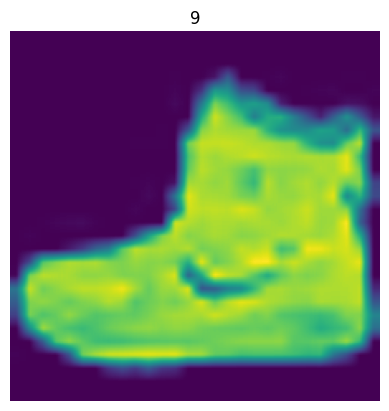

In [16]:
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.axis(False)
plt.title(label)

(-0.5, 223.5, 223.5, -0.5)

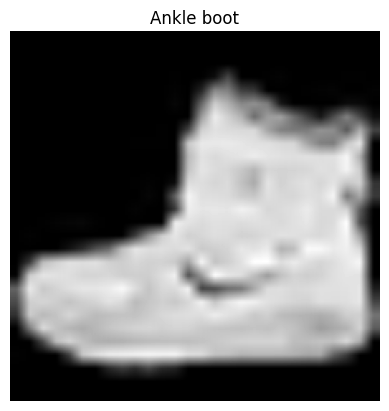

In [17]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [18]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

In [19]:
print(f"Length of train_dataLoaders: {len(train_dataloader)} batches of {BATCH_SIZE}..")
print(f"Length of train_dataLoaders: {len(test_dataloader)} batches of {BATCH_SIZE}..")

Length of train_dataLoaders: 1875 batches of 32..
Length of train_dataLoaders: 313 batches of 32..


In [20]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 224, 224]), torch.Size([32]))

## Model🤖

In [28]:
# HyperParameters
epochs = 90
lr = 0.001
BATCH_SIZE = 32
num_classes = len(class_names)

In [22]:
class AlexNet(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_features,
                      out_channels=96,
                      kernel_size=11,
                      stride=4,
                      padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2),
            nn.Conv2d(in_channels=96,
                      out_channels=256,
                      kernel_size=5,
                      padding=2,
                     groups=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2),
            nn.Conv2d(in_channels=256,
                      out_channels=384,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=384,
                      out_channels=384,
                      kernel_size=3,
                      padding=1,
                      groups=2),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,
                      out_channels=256,
                      kernel_size=3,
                      padding=1,
                      groups=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*6*6,
                      out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,
                      out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, 
                      out_features=output_features)   
        )
    def forward(self, x):
        x = self.conv_block1(x)
        # print(f"conv block 1: {x.shape}")
        x = self.conv_block2(x)
        # print(f"conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"classifier: {x.shape}")
        return x

In [23]:
model = AlexNet(input_features=1,
                output_features=len(class_names)).to(device)

In [25]:
summary(model, (1, 224, 224), 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 96, 55, 55]          11,712
       BatchNorm2d-2           [32, 96, 55, 55]             192
              ReLU-3           [32, 96, 55, 55]               0
         MaxPool2d-4           [32, 96, 27, 27]               0
            Conv2d-5          [32, 256, 27, 27]         307,456
       BatchNorm2d-6          [32, 256, 27, 27]             512
              ReLU-7          [32, 256, 27, 27]               0
         MaxPool2d-8          [32, 256, 13, 13]               0
            Conv2d-9          [32, 384, 13, 13]         885,120
      BatchNorm2d-10          [32, 384, 13, 13]             768
             ReLU-11          [32, 384, 13, 13]               0
           Conv2d-12          [32, 384, 13, 13]         663,936
      BatchNorm2d-13          [32, 384, 13, 13]             768
             ReLU-14          [32, 384,

In [26]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr,momentum=0.9,weight_decay=0.0005)
accuracy_fn = accuracy_fn
# scheduler = torch.optim.lr_scheduler()

In [30]:
from tqdm.notebook import tqdm

In [32]:
# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch}\n------")
#     train_loss = 0
#     for batch, (X_train, y_train) in enumarate(train_loader):
#         model.train()
#         y_pred = model(X_train)
#         loss = loss_fn(y_pred, y_train)
#         train_loss += loss
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 200 == 0:
#             print(f"Finished with {batch * len(X)}/{len(train_dataloader)} samples")
#         train_loss /= len(train_loader)

#     test_loss, test_acc = 0, 0
#     model_0.eval()
#     with torch.inference_mode():
#         for X_test, y_test in test_dataloader:
#             test_pred = model(X_test)
            
#             test_loss += loss_fn(test_pred, y_test)
#             test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

#         test_loss /= len(test_dataloader)
#         test_acc /= len(test_dataloader)

# print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}%")

In [33]:
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.dtype

(torch.Size([32, 1, 224, 224]), torch.int64)

In [42]:
x_, y_ = next(iter(test_dataloader))
y_

tensor([4, 5, 7, 8, 8, 3, 2, 3, 8, 5, 4, 6, 5, 9, 2, 9, 3, 7, 8, 4, 5, 2, 9, 1,
        6, 2, 4, 4, 3, 3, 9, 6])